### Problem Understanding:
    
This challenge proposes a problem where a prediction is required to identify a shoper's likelihood to return to the stores considering his past shopping behaviour which would help the company to target specific customers by providing promotional offers,discounts etc which would in turn increase their revenue. 

Dataset contains customer id's with their different visits to the mall on different dates. Units purchased and total spend details are provided for each visit.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

#### Importing data and specifying order_date as datetime object

In [2]:
%matplotlib inline
dicPath = os.getcwd()
dicPathData = os.path.join(dicPath,'dataset.csv')
dataset = pd.read_csv(dicPathData ,parse_dates=['order_date'])
dataset.head()

,cust_id,order_date,lane_number,total_spend,units_purchased
0,4239597436,2015-03-20,3,19.84,5
1,4913827536,2015-03-20,3,11.1,5
2,4913827536,2015-03-20,1,10,1
3,4271866537,2015-03-20,5,13.68,2
4,5316845735,2015-03-20,4,5.29,1


### Data preprocessing

#### 1) Type casting column

In [3]:
dataset.dtypes

cust_id                     int64
order_date         datetime64[ns]
lane_number                 int64
total_spend                object
units_purchased             int64
dtype: object

#### We can see that "total_spend" is of type "object".We need to convert into "float" type column.

In [4]:
dataset['total_spend'] = pd.to_numeric(dataset.total_spend, errors='coerce')
dataset.dtypes

cust_id                     int64
order_date         datetime64[ns]
lane_number                 int64
total_spend               float64
units_purchased             int64
dtype: object

#### 2) Checking for null values.If found replacing it with suitable statistic criteria

In [5]:
dataset.isnull().sum()

cust_id             0
order_date          0
lane_number         0
total_spend        15
units_purchased     0
dtype: int64

#### We can see there are missing values in total_spend column.We can replace missing values with mean

In [6]:
dataset = dataset.fillna(dataset.mean())

In [7]:
dataset.isnull().sum()

cust_id            0
order_date         0
lane_number        0
total_spend        0
units_purchased    0
dtype: int64

#### Finding minimum and maximum date which would be used in later analysis

In [8]:
min_date = dataset['order_date'].min()
min_date

Timestamp('2015-03-20 00:00:00')

In [9]:
max_date = dataset['order_date'].max()
max_date

Timestamp('2016-03-27 00:00:00')

#### Finding out the number of times customer went to the store on the paritcular date,so that it can be useful during predictive analysis in later stages

In [10]:
dataset['count'] = dataset.groupby(['cust_id','order_date'])['cust_id'].transform('count')

In [11]:
dataset.head()

,cust_id,order_date,lane_number,total_spend,units_purchased,count
0,4239597436,2015-03-20,3,19.84,5,1
1,4913827536,2015-03-20,3,11.10,5,2
2,4913827536,2015-03-20,1,10.00,1,2
3,4271866537,2015-03-20,5,13.68,2,2
4,5316845735,2015-03-20,4,5.29,1,1


#### RFM (Recency, Frequency, & Monetary) Model
    RFM model is a classic analytics and segmentation tool for identifying best customers.
    
    Fundamentals of RFM -
        
        1) have made a purchase recently,
        2) make regular or frequent purchases with you,
        3) spend a large amount with you, are more likely to return to the store.



#### In our dataset we do not need to generate any new training or testing attributes as we can easily RFM on our data set,sicne we have the relavant information we need like 
    1) Recency - Order date is provided
    2) Frequency - we have already computed frequencies(count) above
    3) Montary value - Total spend and units purchased attributes are provided.

#### To calculate recency, we need to choose a date point from which we evaluate how many days ago was the customer's last purchase.The last date we have is 2016-03-27 and we will use it for our analysis.

In [12]:
NOW = dt.datetime(2016,3,27)

In [13]:
rfmTable = dataset.groupby('cust_id').agg({'order_date': lambda x: (NOW - x.max()).days, 'count': lambda x: len(x), 'total_spend': lambda x: x.sum()})
rfmTable['order_date'] = rfmTable['order_date'].astype(int)
rfmTable.rename(columns={'order_date': 'recency', 
                         'count': 'frequency', 
                         'total_spend': 'monetary_value'}, inplace=True)
rfmTable.head()

,recency,frequency,monetary_value
cust_id,,,
4005940437,0,202,2225.08
4005940737,5,7,63.15
4005941333,1,47,1359.24
4005941434,0,89,676.81
4005941533,2,79,2351.00


#### Above table shows the RFM table for each customer

### Now we will divide the RFM table into various segments using quartiles which will help us in segmenting the customers

In [14]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [15]:
segmented_rfm = rfmTable

#### Assigning RFM scores based on the quartiles,which will give insights for the important customers

In [16]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

#### Applying these scores for segemented RFM table 

In [17]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
cust_id,,,,,,
4005940437,0,202,2225.08,1,1,1
4005940737,5,7,63.15,3,3,4
4005941333,1,47,1359.24,1,1,1
4005941434,0,89,676.81,1,1,1
4005941533,2,79,2351.00,2,1,1


In [18]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) \
                            + segmented_rfm.f_quartile.map(str) \
                            + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
cust_id,,,,,,,
4005940437,0,202,2225.08,1,1,1,111
4005940737,5,7,63.15,3,3,4,334
4005941333,1,47,1359.24,1,1,1,111
4005941434,0,89,676.81,1,1,1,111
4005941533,2,79,2351.00,2,1,1,211


#### Finding the sum of RFM score for individual customer

In [19]:
segmented_rfm['RFM_level_Score'] = segmented_rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
segmented_rfm['RFM_level_Score'].head()

cust_id
4005940437     3
4005940737    10
4005941333     3
4005941434     3
4005941533     4
Name: RFM_level_Score, dtype: int64

#### Defining RFM level function which will assign the tag for the customers based on their RFM level score,whcih indicates whether the customer will return to the store or not

In [20]:
# Define rfm_level function
def rfm_level(segmented_rfm):
    if segmented_rfm['RFM_level_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((segmented_rfm['RFM_level_Score'] >= 8) and (segmented_rfm['RFM_level_Score'] < 9)):
        return 'Champions'
    elif ((segmented_rfm['RFM_level_Score'] >= 7) and (segmented_rfm['RFM_level_Score'] < 8)):
        return 'Loyal'
    elif ((segmented_rfm['RFM_level_Score'] >= 6) and (segmented_rfm['RFM_level_Score'] < 7)):
        return 'Potential'
    elif ((segmented_rfm['RFM_level_Score'] >= 5) and (segmented_rfm['RFM_level_Score'] < 6)):
        return 'Promising'
    elif ((segmented_rfm['RFM_level_Score'] >= 4) and (segmented_rfm['RFM_level_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'


In [21]:
segmented_rfm['RFM_Level'] = segmented_rfm.apply(rfm_level, axis=1)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,RFM_level_Score,RFM_Level
cust_id,,,,,,,,,
4005940437,0,202,2225.08,1,1,1,111,3,Require Activation
4005940737,5,7,63.15,3,3,4,334,10,Can't Loose Them
4005941333,1,47,1359.24,1,1,1,111,3,Require Activation
4005941434,0,89,676.81,1,1,1,111,3,Require Activation
4005941533,2,79,2351.00,2,1,1,211,4,Needs Attention


#### finding average values for each RFM level and the count of segmented customers in each RFM level

In [22]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = segmented_rfm.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

                   recency frequency monetary_value      
                      mean      mean           mean count
RFM_Level                                                
Can't Loose Them       4.1       5.5           86.8  4537
Champions              3.6      14.4          253.6  1547
Loyal                  3.1      19.1          364.3  1534
Needs Attention        1.8      61.2         1313.9  1127
Potential              3.3      31.5          660.7  1500
Promising              2.5      42.0          907.7  1421
Require Activation     0.6      86.2         1789.6   823


From here, we can see that a large percentage (~60%) of our customers are in the top tier RFM levels. The company must be doing something right to be maintaining their loyalty.

The other 40% will need some work. Let’s explore using some ads to re-target them:

Potential — high potential to enter our loyal customer segments, why not throw in some freebies on their next purchase to show that you value them!

Promising — showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.

Needs Attention — made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.

Require Activation — Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.

#### There are around 4500 customers which the company cant loose which is labelled as "Cant loose them".If the company focus on these customers specifically by providing extra benefits or perks, it will help their customer retention by 36%.

#### Plotting to see the customer segmentation based on RFM level

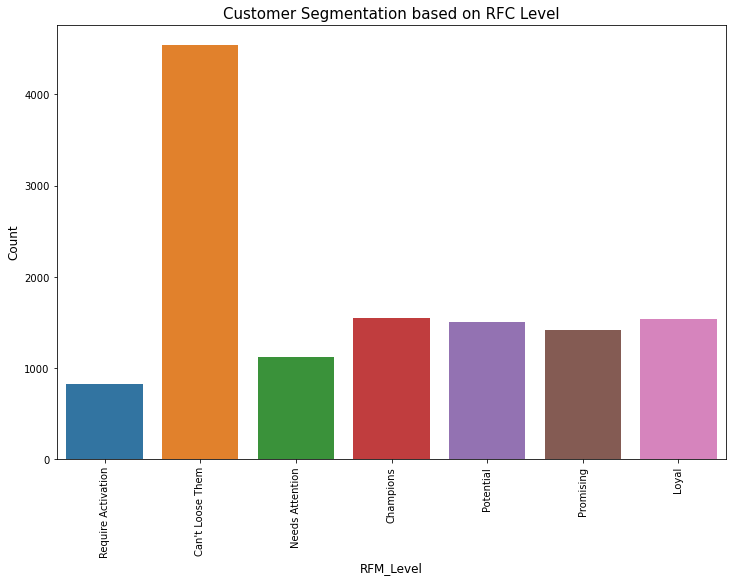

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(x='RFM_Level', data=segmented_rfm)
plt.ylabel('Count', fontsize=12)
plt.xlabel('RFM_Level', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Customer Segmentation based on RFC Level', fontsize=15)
plt.show()